In [1]:
!python -V

Python 3.9.16


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

import pickle

In [3]:
import mlflow

# I need this because I am running with SQLite in the backend
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/Users/tdafonseca/Desktop/Github/learning/deploy_machine_learning_model/02-experiment-tracking/mlruns/2', creation_time=1686172186899, experiment_id='2', last_update_time=1686172186899, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:

df = pd.read_parquet("../data/green_tripdata_2023-01.parquet")

df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
  
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)


7.059008426572675

/var/folders/y1/h3rdxlrj2qvdwwjh6r3b721m0000gp/T/ipykernel_9197/851605343.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction');
/var/folders/y1/h3rdxlrj2qvdwwjh6r3b721m0000gp/T/ipykernel_9197/851605343.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label=

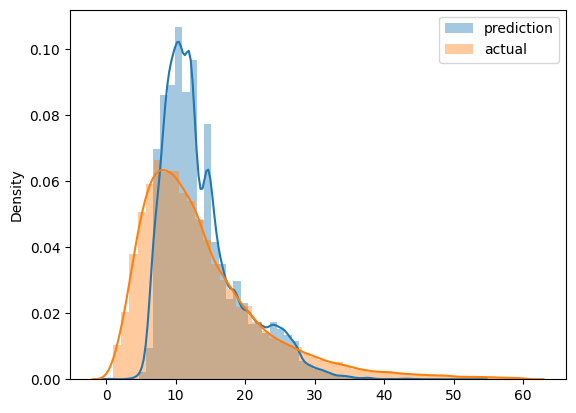

In [8]:
sns.distplot(y_pred, label='prediction');
sns.distplot(y_train, label='actual');

plt.legend();

In [9]:
def read_dataframe(filename):
    '''Data preprocessing
    '''
    df = pd.read_parquet(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [10]:
df_train = read_dataframe('../data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2023-02.parquet')

In [11]:
len(df_train),len(df_val)

(65946, 62574)

In [12]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:
categorical = ['PU_DO']#'PULocationID','DOLocationID']
numerical = ['trip_distance'] 

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
# target
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values  

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.034419810892012

In [17]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.742639978491274

In [18]:
lr = Ridge(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.028138722401977

In [19]:
with open('models/ling_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [20]:
# keep track of my ml experiments
with mlflow.start_run():
    
    mlflow.set_tag("developer","tomas")
    
    #parameters of the model and which data
    mlflow.log_param("train-data-path", "../data/green_tripdata_2023-01.parquet")
    mlflow.log_param("validation-data-path", "../data/green_tripdata_2023-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Ridge(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)